# Binary Group Composition with $C_n$

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator

## Dataset

In [106]:
def one_hot(p):
    """One-hot encode an integer value in R^p."""
    vec = np.zeros(p)
    vec[0] = 1
    return vec

def generate_template(p, magnitude, exponent):
    weight = magnitude * np.power(np.arange(1, p), -exponent)  # Power-law singular values
    template = np.ones(p)  # Base term (DC component)
    for freq in range(1, p):
        template += weight[freq-1] * np.cos(np.arange(p) * freq / p * 2 * np.pi)
    return template / p

def generate_fixed_template(p):
    # Generate template array from Fourier spectrum
    spectrum = np.zeros(p, dtype=complex)
    
    # Set only three frequencies with specific amplitudes
    spectrum[1] = 12.5 # Positive frequency
    spectrum[-1] = 12.5  # Negative frequency (conjugate)
    spectrum[2] = 10 # Positive frequency
    spectrum[-2] = 10  # Negative frequency (conjugate)
    spectrum[3] = 7.5 # Second frequency
    spectrum[-3] =  7.5  # Its conjugate
    spectrum[4] = 5 # Second frequency
    spectrum[-4] =  5  # Its conjugate
    spectrum[5] = 2.5  # Third frequency 
    spectrum[-5] = 2.5  # Its conjugate
    
    # Generate signal from spectrum
    template = np.fft.ifft(spectrum).real

    return template

def ModularAdditionDataset(p, template):
    # Initialize data arrays
    X = np.zeros((p * p, 2, p))  # Shape: (p^2, 2, p)
    Y = np.zeros((p * p, p))     # Shape: (p^2, p)
    
    # Generate the dataset
    idx = 0
    for a in range(p):
        for b in range(p):
            q = (a + b) % p  # a + b mod p
            X[idx, 0, :] = np.roll(template, a)
            X[idx, 1, :] = np.roll(template, b)
            Y[idx, :] = np.roll(template, q)
            idx += 1
            
    return X, Y

## Architecture

In [107]:
class TwoLayerNet(nn.Module):
    def __init__(self, p, hidden_size, nonlinearity='square', init_scale=1.0, output_scale=1.0):
        super(TwoLayerNet, self).__init__()
        
        # Store dimensions
        self.p = p
        self.hidden_size = hidden_size
        self.nonlinearity = nonlinearity
        self.init_scale = init_scale
        self.output_scale = output_scale
        
        # Initialize parameters 
        self.U = nn.Parameter(self.init_scale * torch.randn(hidden_size, p) / np.sqrt(2 * p))  # First p elements
        self.V = nn.Parameter(self.init_scale * torch.randn(hidden_size, p) / np.sqrt(2 * p))  # Second p elements
        self.W = nn.Parameter(self.init_scale * torch.randn(hidden_size, p) / np.sqrt(p)) # Second layer weights

    def forward(self, x):
        
        # First layer (linear and combined)
        x1 = x[:, :self.p] @ self.U.T
        x2 = x[:, self.p:] @ self.V.T
        x_combined = x1 + x2

        # Apply nonlinearity activation
        if self.nonlinearity == 'relu':
            x_combined = torch.relu(x_combined)
        elif self.nonlinearity == 'square':
            x_combined = x_combined**2
        elif self.nonlinearity == 'linear':
            x_combined = x_combined
        elif self.nonlinearity == 'tanh':
            x_combined = torch.tanh(x_combined)
        elif self.nonlinearity == 'gelu':
            gelu = torch.nn.GELU()
            x_combined = gelu(x_combined)
        else:
            raise ValueError(f"Invalid nonlinearity '{self.nonlinearity}' provided.")

        # Second layer (linear)
        x_out = x_combined @ self.W

        # Feature learning scaling
        x_out *= self.output_scale
        
        return x_out

## Optimization

In [108]:
import torch
from torch import nn

class PerNeuronScaledSGD(torch.optim.Optimizer):
    """
    Per-neuron scaled SGD optimizer that exploits model homogeneity.
    
    Learning rate scaling per neuron i:
        eta_i = lr * ||theta_i||^(2-degree)
    
    where:
        - theta_i comprises all parameters associated with neuron i
        - degree is the degree of homogeneity of the model

    For SequentialMLP with sequence length k:
        - theta_i = (W_in[i, :], W_out[:, i])
        - degree = k+1 (activation is x^k, one more layer for W_out)

    For TwoLayerNet:
        - theta_i = (U[i, :], V[i, :], W[i, :])
        - degree:
            * nonlinearity == 'square' -> 3
            * otherwise default 2 (unless explicitly provided)
    """

    def __init__(self, 
        model, 
        lr=1.0, 
        degree=None
    ) -> None:
        """
        Args:
            model: SequentialMLP, TwoLayerNet, or compatible model
            lr: base learning rate
            degree: degree of homogeneity (exponent for norm-based scaling)
                    If None, inferred from model:
                      - SequentialMLP: uses k+1 where k is sequence length
                      - TwoLayerNet:
                            * 'square'  -> 3
                            * otherwise -> 2
                      - Default: 2
        """
        model_type = type(model).__name__

        # Infer degree of homogeneity from model if not provided
        if degree is None:
            if hasattr(model, 'k'):  # SequentialMLP-style
                degree = model.k + 1
            elif model_type == 'TwoLayerNet':
                nl = getattr(model, 'nonlinearity', None)
                if nl == 'square':
                    degree = 3
                else:
                    # For relu/linear/tanh/gelu or unknown, fall back
                    degree = 2
            else:
                # Default for quadratic-ish models
                degree = 2
        
        # Get model parameters
        params = list(model.parameters())
        
        super().__init__(
            [{'params': params, 'model': model, 'model_type': model_type}], 
            dict(lr=lr, degree=degree)
        )

    @torch.no_grad()
    def step(self, closure=None):
        group = self.param_groups[0]
        model = group['model']
        lr = group['lr']
        degree = group['degree']
        model_type = group['model_type']
        
        if model_type == 'SequentialMLP':
            # SequentialMLP: W_in (d, k*p), W_out (p, d)
            W_in = model.W_in
            W_out = model.W_out
            g_in = W_in.grad
            g_out = W_out.grad
            
            if g_in is None or g_out is None:
                return
            
            # Per-neuron norms: theta_i = (W_in[i, :], W_out[:, i])
            u2 = (W_in**2).sum(dim=1)    # (d,)
            w2 = (W_out**2).sum(dim=0)   # (d,)
            theta_norm = torch.sqrt(u2 + w2 + 1e-12)  # (d,)
            
            # Scale = ||theta_i||^(2-degree)
            scale = theta_norm.pow(2 - degree)
            
            # Scale each neuron's gradients
            g_in.mul_(scale.view(-1, 1))
            g_out.mul_(scale.view(1, -1))
            
            # SGD update
            W_in.add_(g_in, alpha=-lr)
            W_out.add_(g_out, alpha=-lr)

        elif model_type == 'TwoLayerNet':
            # TwoLayerNet: U (d, p), V (d, p), W (d, p)
            U = model.U
            V = model.V
            W = model.W

            g_U = U.grad
            g_V = V.grad
            g_W = W.grad

            if g_U is None or g_V is None or g_W is None:
                return

            # Per-neuron norms: theta_i = (U[i, :], V[i, :], W[i, :])
            u2 = (U**2).sum(dim=1)   # (hidden_size,)
            v2 = (V**2).sum(dim=1)   # (hidden_size,)
            w2 = (W**2).sum(dim=1)   # (hidden_size,)
            theta_norm = torch.sqrt(u2 + v2 + w2 + 1e-12)  # (hidden_size,)

            # Scale = ||theta_i||^(2-degree)
            scale = theta_norm.pow(2 - degree)            # (hidden_size,)

            # Scale each neuron's gradients
            scale_view = scale.view(-1, 1)  # (hidden_size, 1)
            g_U.mul_(scale_view)
            g_V.mul_(scale_view)
            g_W.mul_(scale_view)

            # SGD update
            U.add_(g_U, alpha=-lr)
            V.add_(g_V, alpha=-lr)
            W.add_(g_W, alpha=-lr)

        else:
            raise ValueError(f"PerNeuronScaledSGD: Unsupported model structure with {model_type}")
        
        return None


In [109]:
def test_accuracy(model, dataloader):
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in dataloader:
            inputs = inputs.view(inputs.shape[0], -1)  # Flatten input for FC layers
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the largest value (class)
            _, true_labels = torch.max(labels, 1)  # Get the true class from the one-hot encoding
            correct += (predicted == true_labels).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct / total
    return accuracy

def train(model, dataloader, criterion, optimizer, epochs=100, verbose_interval=10):
    model.train()  # Set the model to training mode
    loss_history = []  # List to store loss values
    accuracy_history = []
    param_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs = inputs.view(inputs.shape[0], -1)  # Flatten input for FC layers

            optimizer.zero_grad()  # Zero gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()

        # Append the average loss for the epoch to loss_history
        avg_loss = running_loss / len(dataloader)
        loss_history.append(avg_loss)

        # Append the accuracy
        model.eval()
        accuracy = test_accuracy(model, dataloader)
        accuracy_history.append(accuracy)
        model.train()

        # Save current model parameters
        current_params = {
            "U": model.U.detach().cpu().clone(),
            "V": model.V.detach().cpu().clone(),
            "W": model.W.detach().cpu().clone()
        }
        param_history.append(current_params)

        # Print verbose information every `verbose_interval` epochs
        if (epoch + 1) % verbose_interval == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return loss_history, accuracy_history, param_history # Return loss history for plotting

## Plotting functions

In [110]:
def style_axes(ax, numyticks=5, numxticks=5, labelsize=24):
    # Y-axis ticks
    ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=labelsize)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=numyticks))
    
    # X-axis ticks
    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=labelsize)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=numxticks))

    # Scientific notation formatting
    if ax.get_yscale() == 'linear':
        ax.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
    if ax.get_xscale() == 'linear':
        ax.ticklabel_format(style='sci', axis='x', scilimits=(-2, 2))

    ax.xaxis.offsetText.set_fontsize(20)
    ax.grid()

    # Customize spines
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_linewidth(3)

In [111]:
def get_power(points):
    p = len(points)
    num_coefficients = (p // 2) + 1
    
    # Perform FFT and calculate power spectrum
    ft = np.fft.fft(points) # Could consider using np.fft.rfft which is designed for real valued input.
    power = np.abs(ft[:num_coefficients])**2 / p
    
    # Double power for frequencies strictly between 0 and Nyquist (Nyquist is not doubled if p is even)
    if p % 2 == 0:  # p is even, Nyquist frequency at index num_coefficients - 1
        power[1:num_coefficients - 1] *= 2
    else:  # p is odd, no Nyquist frequency
        power[1:] *= 2

    # Confirm the power sum approximates the squared norm of points
    total_power = np.sum(power)
    norm_squared = np.linalg.norm(points)**2
    if not np.isclose(total_power, norm_squared, rtol=1e-3):
        print(f"Warning: Total power {total_power:.3f} does not match norm squared {norm_squared:.3f}")

    return np.arange(num_coefficients), power

def interpolate(ax, points, color, continuous, alpha=1.0):
    p = len(points)
    if continuous:
        # Perform Fourier Transform
        ft = np.fft.fft(points)
        
        # Keep only non-negative frequencies (first half + Nyquist if p is even)
        num_coefficients = (p // 2) + 1
        ft = ft[:num_coefficients]  # Truncate to keep non-negative frequencies
        
        # Create a dense set of x-values for smooth interpolation
        xs = np.linspace(0, p, 10 * p)  # 10 times more points than the original for smoothness
        curr_val = np.zeros(xs.shape, dtype=complex)
        
        # Use only non-negative frequencies for interpolation
        for freq in range(num_coefficients):
            theta = np.angle(ft[freq])
            r = np.abs(ft[freq]) / p
            # Double amplitude except for DC (freq = 0) and Nyquist (freq = p / 2, when p is even)
            if freq > 0 and (freq < p / 2 or p % 2 != 0):
                r *= 2
            curr_val += r * np.exp(1j * ((2 * np.pi * freq * xs / p) + theta))

        # Plot the real part (since output is real-valued)
        ax.plot(xs, curr_val.real, color=color, alpha=alpha)
    else:
        ax.plot(np.arange(p), points, color=color, alpha=alpha)   

## Gradient Descent Experiment

In [122]:
seed = 0  # or any integer you like
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using GPU

# Data Generation using the new function
p = 11  # Modulus

# Get base vector
# template = one_hot(p)
template = generate_fixed_template(p)

# Mean center template
template -= np.mean(template)

# Generate dataset using numpy
X, Y = ModularAdditionDataset(p, template)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).view(-1, 2 * p)  # Flatten input (num_samples, 2*p)
Y_tensor = torch.tensor(Y, dtype=torch.float32)  # Targets (num_samples, p)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Initialize model
hidden_size = 200
model = TwoLayerNet(p=p, hidden_size=hidden_size, nonlinearity='square', init_scale=1e-5, output_scale=1e0)

# Create loss function
loss = nn.MSELoss()

# Construct optimizer
lr = 0.01
optimizer = PerNeuronScaledSGD(model, lr=lr, degree=3)  # explicit

# Train the model
epochs = 50001
loss_history, accuracy_history, param_history = train(model, dataloader, loss, optimizer, epochs=epochs, verbose_interval=epochs//10)

Epoch 5000/50001, Loss: 0.1034, Accuracy: 100.00%
Epoch 10000/50001, Loss: 0.1033, Accuracy: 100.00%
Epoch 15000/50001, Loss: 0.1033, Accuracy: 100.00%
Epoch 20000/50001, Loss: 0.1030, Accuracy: 100.00%
Epoch 25000/50001, Loss: 0.0608, Accuracy: 100.00%
Epoch 30000/50001, Loss: 0.0010, Accuracy: 100.00%
Epoch 35000/50001, Loss: 0.0000, Accuracy: 100.00%
Epoch 40000/50001, Loss: 0.0000, Accuracy: 100.00%
Epoch 45000/50001, Loss: 0.0000, Accuracy: 100.00%
Epoch 50000/50001, Loss: 0.0000, Accuracy: 100.00%


## Plot Loss

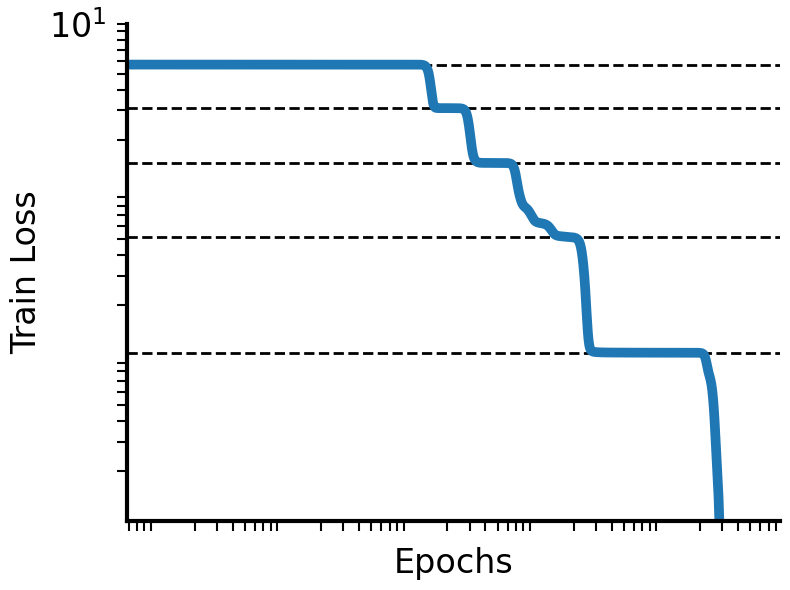

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(list(loss_history), lw=7)

# === Compute power spectrum of template ===
freq, power = get_power(template)
valid = power > 1e-20
freq, power = freq[valid], power[valid]
sorted_idx = np.argsort(-power)
freq, power = freq[sorted_idx], power[sorted_idx]

alpha_values = [np.sum(power[k:]) for k in range(len(power))]
coef = 1 / p
for k, alpha in enumerate(alpha_values):
    ax.axhline(y=coef * alpha, color='black', linestyle='--', linewidth=2, zorder=-2)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-2, 10)
ax.set_xlabel('Epochs', fontsize=24)
ax.set_ylabel('Train Loss', fontsize=24)

style_axes(ax)
plt.grid(False)
plt.tight_layout()
plt.savefig("loss-without-lines.pdf", bbox_inches="tight")
plt.show()

## Power Spectrum of output

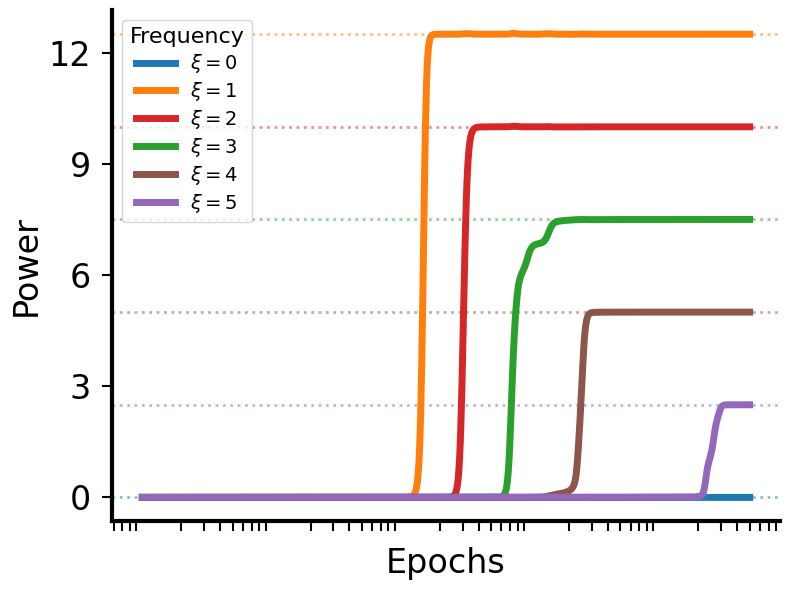

In [134]:
# === SETTINGS ===
p = Y_tensor.shape[1]
num_freqs = p // 2 + 1

# Compute template power spectrum
template_ft = np.fft.rfft(template)
template_power = np.abs(template_ft)[:num_freqs]

# === Compute power spectrum of template ===
freq, power = get_power(template)
valid = power > 1e-20
freq, power = freq[valid], power[valid]
sorted_idx = np.argsort(-power)
freq, power = freq[sorted_idx], power[sorted_idx]

# === Theory lines ===
alpha_values = [np.sum(power[k:]) for k in range(len(power))]
coef = 1 / p
theta0 = np.sqrt(2) * model.init_scale
uMax = [np.sqrt(2 * p / 27) * (p * power[k] / 2)**(3/2) / p**2 for k in range(len(power))]
tau_values = [(1 / theta0 - 1) / (3 * uMax[k]) for k in range(len(uMax))]
step_size = 2 * coef * lr / (1 - mom)


# Color settings
cmap = plt.colormaps.get_cmap('tab20').resampled(num_freqs)
manual_colors = {
    0: 'tab:blue',
    1: 'tab:orange',
    2: 'tab:red',
    3: 'tab:green',
    4: 'tab:brown',
    5: 'tab:purple',
}
colors = [manual_colors.get(i, cmap(i)) for i in range(num_freqs)]

# Compute output power over time (GD)
num_points = 1000
steps = np.unique(np.logspace(0, np.log10(len(param_history) - 1), num_points, dtype=int))
powers_over_time = []

for step in steps:
    model.load_state_dict(param_history[step])
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        ft = np.fft.rfft(outputs.detach().cpu().numpy(), axis=1)
        avg_power = np.mean(np.abs(ft), axis=0)
        powers_over_time.append(avg_power)

powers_over_time = np.array(powers_over_time)  # shape: (steps, freqs)

# === PLOTTING ===
fig, ax = plt.subplots(figsize=(8, 6))

for k in range(num_freqs):
    color = colors[k]
    label = fr"$\xi = {k}$"# if k in [1, 3, 5] else None
    ax.plot(steps, powers_over_time[:, k], color=color, lw=5, label=label)
    label_agf = 'AGF' if k == 10 else None
    ax.axhline(template_power[k], color=color, linestyle='dotted', linewidth=2, alpha=0.5, zorder=-10)


# Labeling and formatting
ax.set_xscale('log')
ax.set_ylabel("Power", fontsize=24)
ax.set_xlabel("Epochs", fontsize=24)
ax.legend(fontsize=14, title="Frequency", title_fontsize=16, loc='upper left', labelspacing=0.25)
style_axes(ax)
ax.grid(False)
plt.tight_layout()
plt.savefig("fourier_power_only.pdf", bbox_inches="tight")
plt.show()

## Plot outputs

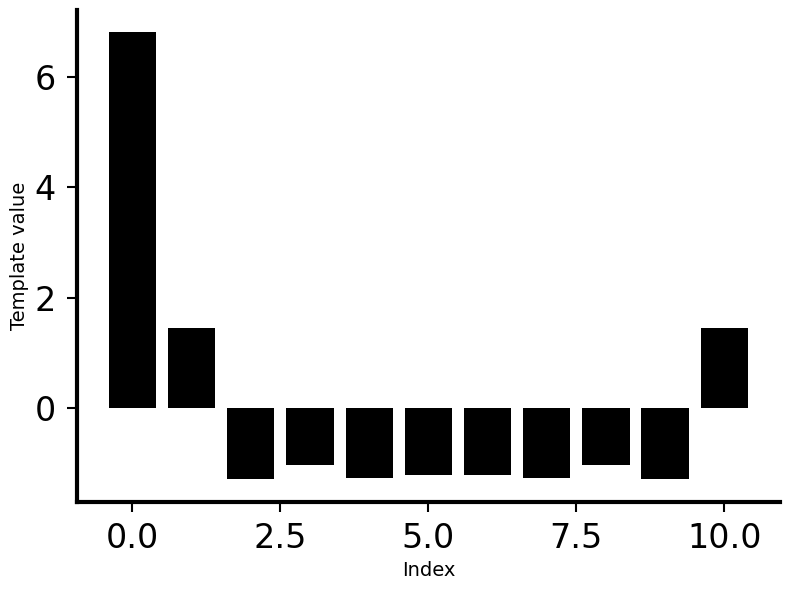

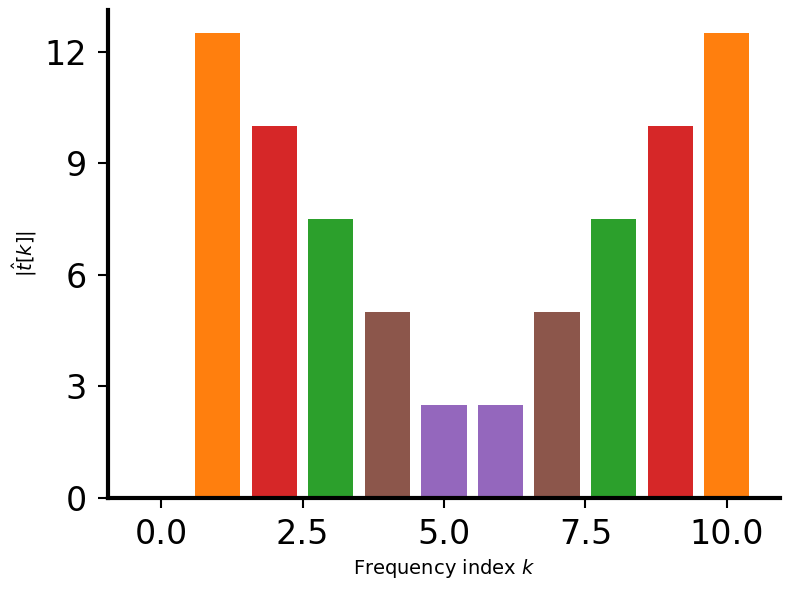

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# -------------------------------------------------------------------
# Choose the template (example: first row of Y_tensor)
# -------------------------------------------------------------------
template = Y_tensor[0].detach().cpu().numpy()  # shape (p,)
p = template.shape[0]
x = np.arange(p)

# -------------------------------------------------------------------
# Figure 1: Template as black bar plot
# -------------------------------------------------------------------
fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.bar(x, template, color="black")

ax1.set_xlabel("Index", fontsize=14)
ax1.set_ylabel("Template value", fontsize=14)
style_axes(ax1)
ax1.grid(False)

plt.tight_layout()
fig1.savefig("template_bar.pdf", bbox_inches="tight")

# -------------------------------------------------------------------
# Figure 2: Fourier magnitude bar plot with conjugate-pair coloring
# -------------------------------------------------------------------
# Compute Fourier transform and magnitude
fft_template = np.fft.fft(template)
fft_mag = np.abs(fft_template)
freqs = np.arange(p)

# Number of *frequency groups* accounting for conjugate symmetry:
# groups: 0, 1, ..., floor(p/2)
num_groups = p // 2 + 1

# Color settings
cmap = plt.colormaps.get_cmap('tab20').resampled(num_groups)
manual_colors = {
    0: 'tab:blue',
    1: 'tab:orange',
    2: 'tab:red',
    3: 'tab:green',
    4: 'tab:brown',
    5: 'tab:purple',
}
group_colors = [manual_colors.get(i, cmap(i)) for i in range(num_groups)]

# Assign each k a color based on its conjugate-symmetry group
bar_colors = []
for k in range(p):
    # group index: k and p-k share the same group
    g = k if k <= p // 2 else p - k
    bar_colors.append(group_colors[g])

fig2, ax2 = plt.subplots(figsize=(8, 6))
ax2.bar(freqs, fft_mag, color=bar_colors)

ax2.set_xlabel("Frequency index $k$", fontsize=14)
ax2.set_ylabel(r"$|\hat{t}[k]|$", fontsize=14)
style_axes(ax2)
ax2.grid(False)

plt.tight_layout()
fig2.savefig("template_fft_bar.pdf", bbox_inches="tight")